In [239]:
from leicaexperiment import Experiment
from skimage import io

e = Experiment('data/experiment--2015_03_21_17_09_56 kopi')
image = io.imread(e.image(0,0,0,0))
offset_image = io.imread(e.image(0,0,1,0))

In [240]:
from skimage import feature
#image = feature.canny(image)
#offset_image = feature.canny(offset_image)

In [241]:
%matplotlib inline

# using register translation

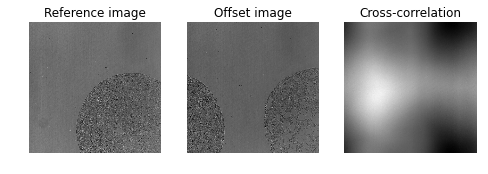

Detected pixel offset (y, x):
[  0. -58.]


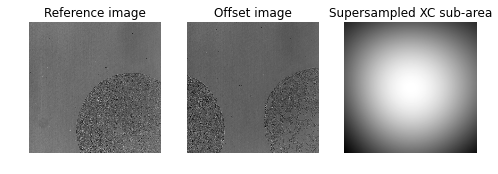

Detected subpixel offset (y, x):
[ -0.08 -58.06]


In [242]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage.fourier import fourier_shift

#image = data.camera()
#shift = (-2.4, 1.32)
# (-2.4, 1.32) pixel offset relative to reference coin
#offset_image = fourier_shift(np.fft.fftn(image), shift)
#offset_image = np.fft.ifftn(offset_image)
#print("Known offset (y, x):")
#print(shift)

# pixel precision first
shift, error, diffphase = register_translation(image, offset_image)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 3))

ax1.imshow(image)
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real)
ax2.set_axis_off()
ax2.set_title('Offset image')

# View the output of a cross-correlation to show what the algorithm is
#    doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print("Detected pixel offset (y, x):")
print(shift)

# subpixel precision
shift, error, diffphase = register_translation(image, offset_image, 100)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 3))

ax1.imshow(image)
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real)
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
#    behind the scenes.  Constants correspond to calculated values in routine.
#    See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print("Detected subpixel offset (y, x):")
print(shift)

# using orb + ransac
from https://peerj.com/articles/453/#p-1

In [269]:
#image0 = feature.canny(image)
#image1 = feature.canny(offset_image)
image0 = image[:,256:]
image1 = offset_image[:,:256]

In [270]:
from skimage.feature import ORB, match_descriptors, CENSURE

orb = ORB(n_keypoints=1000)

orb.detect_and_extract(image0)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(image1)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

matches12 = match_descriptors(descriptors1,
                              descriptors2,
                              max_distance=1,
                              cross_check=True)

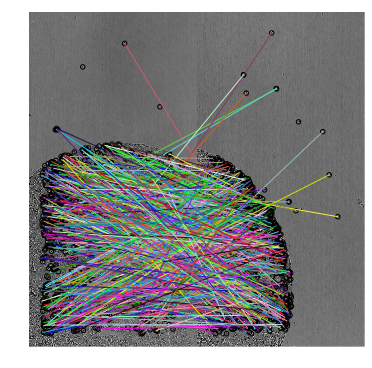

In [271]:
plt.figure(figsize=(12,6))
ax = plt.axes()
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12)
ax.axis('off');

In [272]:
offset = keypoints1[matches12[:, 0]] - keypoints2[matches12[:, 1]]

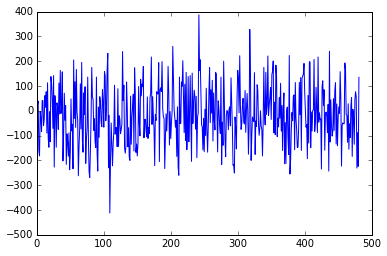

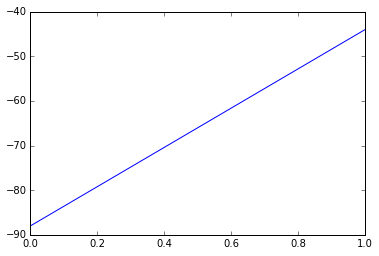

In [281]:
plt.plot([x[0] for x in offset])
plt.figure()
plt.plot(sorted([x[1] for x in offset if x[0] == 3]))

In [218]:
from skimage import feature

daisy = feature.daisy(image1)

In [219]:
daisy.shape

(121, 21, 200)

In [ ]:
plt.figure(figsize=(12,6))
ax = plt.axes()
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12)
ax.axis('off');

In [155]:
from skimage.measure import ransac
from skimage import transform

# Select keypoints from the source (image to be
# registered) and target (reference image).

src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

In [166]:
model_robust, inliers = \
    ransac((src, dst), transform.AffineTransform,
           min_samples=100, residual_threshold=2)

LinAlgError: Arrays cannot be empty

In [163]:
sum(inliers)

5

(0.0, 224.0, 512.0, 0.0)

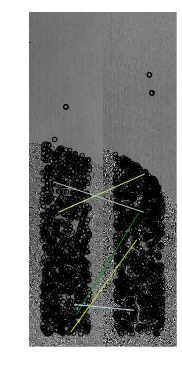

In [164]:
plt.figure(figsize=(12,6))
ax = plt.axes()
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12[inliers])
ax.axis('off')

In [16]:
r, c = image1.shape[:2]

# Note that transformations take coordinates in
# (x, y) format, not (row, column), in order to be
# consistent with most literature.
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions.
warped_corners = model_robust(corners)

# Find the extents of both the reference image and
# the warped target image.
all_corners = np.vstack((warped_corners, corners))

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)

output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1])

In [17]:
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from skimage.transform import warp
from skimage.transform import SimilarityTransform

offset = SimilarityTransform(translation=-corner_min)

image0_ = warp(image0, offset.inverse,
               output_shape=output_shape, cval=-1)

image1_ = warp(image1, (model_robust + offset).inverse,
               output_shape=output_shape, cval=-1)

In [18]:
def add_alpha(image, background=-1):
    """Add an alpha layer to the image.

    The alpha layer is set to 1 for foreground
    and 0 for background.
    """
    rgb = gray2rgb(image)
    alpha = (image != background)
    return np.dstack((rgb, alpha))

image0_alpha = add_alpha(image0_)
image1_alpha = add_alpha(image1_)

merged = (image0_alpha + image1_alpha)
alpha = merged[..., 3]

# The summed alpha layers give us an indication of
# how many images were combined to make up each
# pixel.  Divide by the number of images to get
# an average.
merged /= np.maximum(alpha, 1)[..., np.newaxis]

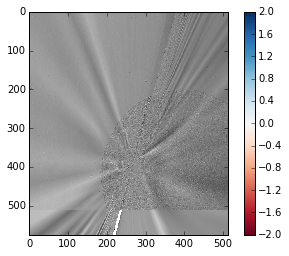

In [19]:
io.imshow(merged)

# BRIEF

(0.0, 1024.0, 512.0, 0.0)

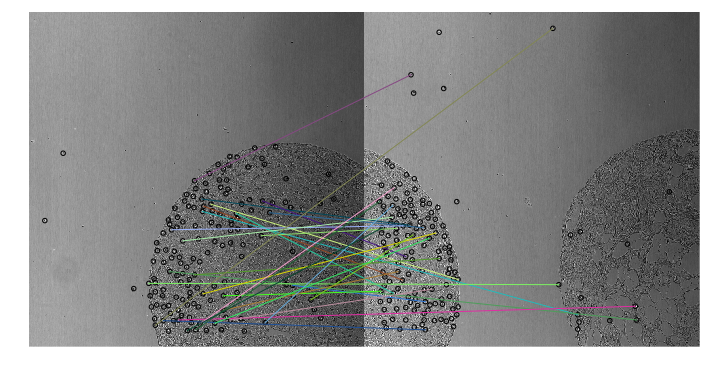

In [36]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


img1 = image
img2 = offset_image

keypoints1 = corner_peaks(corner_harris(img1), min_distance=5)
keypoints2 = corner_peaks(corner_harris(img2), min_distance=5)

extractor = BRIEF()

extractor.extract(img1, keypoints1)
keypoints1 = keypoints1[extractor.mask]
descriptors1 = extractor.descriptors

extractor.extract(img2, keypoints2)
keypoints2 = keypoints2[extractor.mask]
descriptors2 = extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, max_distance=img1.shape[0]*0.2,
                              metric='cityblock', cross_check=True)

plt.figure(figsize=(12,6))
ax = plt.axes()
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax.axis('off')